# Datasets comparison between CAMS and IASI (L3)

## Imports and supporting functions

In [2]:
# Related to the system
import os 

# Related to the data retrieval
from sentinelsat.sentinel import SentinelAPI, geojson_to_wkt
import cdsapi
import cfgrib
import geojson
import urllib3

# Related to the data analysis
import math
import xarray as xr
import pandas as pd
import numpy as np
import datetime as dt
from itertools import product
import scipy.interpolate
from scipy.spatial.distance import cdist
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# Related to the results
from copy import copy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import geocoder
import seaborn as sns
from matplotlib import animation
from IPython.display import HTML, display
import warnings

In [3]:
%run functions/functions_general.ipynb
%run functions/functions_cams.ipynb
%run functions/functions_iasi.ipynb

In [4]:
# Hide pandas warning
pd.options.mode.chained_assignment = None

# Hide API request warning
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# Increase animation limit
matplotlib.rcParams['animation.embed_limit'] = 25000000

# Hide labels animation warning
warnings.filterwarnings('ignore', category = UserWarning, module='cartopy')

## 1. Define datasets

In [5]:
# Define component (CO or O3)
component_nom = 'CO'

# Define model
model = 'cams'
model_full_name = 'cams-global-reanalysis-eac4-monthly'

# Define sensor
sensor = 'iasi'
sensor_type = 'L3'
satellites = ['A', 'B', 'C']
apply_kernels = False

# Define search period
start_date = '2018-01-01'
end_date = '2020-12-01'

# Define extent
area_name = 'Spain'
lon_min = -20
lon_max = 5
lat_min = 27
lat_max = 45

# Define resolution (Minimum: 1x1)
lat_res = 1
lon_res = 1

In [6]:
# Check if comparison is possible
comparison_check(sensor, model, component_nom, model_full_name, sensor_type, apply_kernels)

# Get component full name and molecular weight
component, component_mol_weight, product_type, sensor_column, column_type = components_table(sensor, component_nom, sensor_type)

# Folders generation
generate_folders(model, sensor, component_nom, sensor_type)

The comparison is possible and will start now.


In [7]:
# Generate array with search dates
dates = search_period(start_date, end_date, sensor, sensor_type)

# Create bbox
bbox = search_bbox(lon_min, lat_min, lon_max, lat_max)

SEARCH PERIOD
- In months: ('2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2019-01', '2019-02', '2019-03', '2019-04', '2019-05', '2019-06', '2019-07', '2019-08', '2019-09', '2019-10', '2019-11', '2019-12', '2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12')
SEARCH BOUNDING BOX
Latitudes: from 27 to 45
Longitudes: from -20 to 5


## 2. Model data

### Download and read data as xarray

In [8]:
model_product_name, model_type = CAMS_download(dates, start_date, end_date, component, component_nom, 
                                               lat_min, lat_max, lon_min, lon_max, area_name, model_full_name,
                                               model_level = 'Single', CAMS_UID = None, CAMS_key = None)

The file exists, it will not be downloaded again.


In [9]:
model_ds, dates, model_levels_df = CAMS_read(model_product_name, component, component_nom, dates)
model_ds

<xarray.Dataset>
Dimensions:     (latitude: 25, longitude: 34, time: 36)
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 2018-01-01 2018-02-01 ... 2020-12-01
    surface     float64 ...
  * latitude    (latitude) float64 27.0 27.75 28.5 29.25 ... 43.5 44.25 45.0
  * longitude   (longitude) float64 -20.0 -19.25 -18.5 -17.75 ... 3.25 4.0 4.75
    valid_time  (time) datetime64[ns] ...
Data variables:
    component   (time, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2022-01-13T11:02 GRIB to CDM+CF via cfgrib-0.9.9...

### Collect 137 levels model data

In [10]:
model_levels_df

,a [Pa],b,ph [hPa],pf [hPa],Geopotential Altitude [m],Geometric Altitude [m],Temperature [K],Density [kg/m^3],ph [Pa],Depth [m]
hybrid,,,,,,,,,,
1,2.000365,0.000000,0.0200,0.0100,79301.79,80301.65,198.05,0.000018,2.00,5580.21
2,3.102241,0.000000,0.0310,0.0255,73721.58,74584.91,209.21,0.000042,3.10,2605.83
3,4.666084,0.000000,0.0467,0.0388,71115.75,71918.79,214.42,0.000063,4.67,2497.32
4,6.827977,0.000000,0.0683,0.0575,68618.43,69365.77,221.32,0.000090,6.83,2407.44
5,9.746966,0.000000,0.0975,0.0829,66210.99,66906.53,228.06,0.000127,9.75,2320.96
...,...,...,...,...,...,...,...,...,...,...
133,62.781250,0.988500,1002.2250,1000.5165,106.54,106.54,287.46,1.212498,100222.50,27.50
134,22.835938,0.991984,1005.3562,1003.7906,79.04,79.04,287.64,1.215710,100535.62,25.12
135,3.757813,0.995003,1008.2239,1006.7900,53.92,53.92,287.80,1.218650,100822.39,22.96


### Convert CAMS data units (kg/m2 to molecules/cm<sup>2</sup>)

In [11]:
model_ds, units = model_convert_units(model, model_ds, sensor, 
                                      component_mol_weight, model_levels_df,
                                      start_date, end_date, component_nom, apply_kernels,
                                      CAMS_UID = None, CAMS_key = None)

The model component units have been converted from kg m**-2 to molec cm-2.


In [12]:
model_ds

<xarray.Dataset>
Dimensions:     (latitude: 25, longitude: 34, time: 36)
Coordinates:
    number      int64 0
  * time        (time) datetime64[ns] 2018-01-01 2018-02-01 ... 2020-12-01
    surface     float64 0.0
  * latitude    (latitude) float64 27.0 27.75 28.5 29.25 ... 43.5 44.25 45.0
  * longitude   (longitude) float64 -20.0 -19.25 -18.5 -17.75 ... 3.25 4.0 4.75
    valid_time  (time) datetime64[ns] 2018-01-01 2018-02-01 ... 2020-12-01
Data variables:
    component   (time, latitude, longitude) float32 1.71e+18 ... 1.709e+18
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2022-01-13T11:02 GRIB to CDM+CF via cfgrib-0.9.9...

### Get CAMS levels (total or tropospheric)

In [13]:
model_ds = CAMS_get_levels_data(model_ds, model_product_name, model_levels_df, 
                                column_type, lat_min, lat_max, lon_min, lon_max)
model_ds

The model total columns will be compared to the total sensor columns.


<xarray.Dataset>
Dimensions:     (latitude: 25, longitude: 34, time: 36)
Coordinates:
    number      int64 0
  * time        (time) datetime64[ns] 2018-01-01 2018-02-01 ... 2020-12-01
    surface     float64 0.0
  * latitude    (latitude) float64 27.0 27.75 28.5 29.25 ... 43.5 44.25 45.0
  * longitude   (longitude) float64 -20.0 -19.25 -18.5 -17.75 ... 3.25 4.0 4.75
    valid_time  (time) datetime64[ns] 2018-01-01 2018-02-01 ... 2020-12-01
Data variables:
    component   (time, latitude, longitude) float32 1.71e+18 ... 1.709e+18
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2022-01-13T11:02 GRIB to CDM+CF via cfgrib-0.9.9...

## 3. Sensor data

In [14]:
dates = sensor_download(sensor, sensor_type, component_nom, dates, satellites)

RESULTS
For 2018-01:
IASI_METOPA_L3_CO_COLUMN_201801_ULB-LATMOS_V20151001.0.nc was downloaded.
IASI_METOPB_L3_CO_COLUMN_201801_ULB-LATMOS_V20151001.0.nc was downloaded.
IASI_METOPC_L3_CO_COLUMN_201801_ULB-LATMOS_V20151001.0.nc is not available.
For 2018-02:
IASI_METOPA_L3_CO_COLUMN_201802_ULB-LATMOS_V20151001.0.nc was downloaded.
IASI_METOPB_L3_CO_COLUMN_201802_ULB-LATMOS_V20151001.0.nc was downloaded.
IASI_METOPC_L3_CO_COLUMN_201802_ULB-LATMOS_V20151001.0.nc is not available.
For 2018-03:
IASI_METOPA_L3_CO_COLUMN_201803_ULB-LATMOS_V20151001.0.nc was downloaded.
IASI_METOPB_L3_CO_COLUMN_201803_ULB-LATMOS_V20151001.0.nc was downloaded.
IASI_METOPC_L3_CO_COLUMN_201803_ULB-LATMOS_V20151001.0.nc is not available.
For 2018-04:
IASI_METOPA_L3_CO_COLUMN_201804_ULB-LATMOS_V20151001.0.nc was downloaded.
IASI_METOPB_L3_CO_COLUMN_201804_ULB-LATMOS_V20151001.0.nc was downloaded.
IASI_METOPC_L3_CO_COLUMN_201804_ULB-LATMOS_V20151001.0.nc is not available.
For 2018-05:
IASI_METOPA_L3_CO_COLUMN_201805

In [15]:
sensor_ds, _, _ = sensor_read(sensor, sensor_type, sensor_column, component_nom, dates, lat_res, lon_res)
sensor_ds

<xarray.Dataset>
Dimensions:         (latitude: 180, longitude: 360, time: 35)
Coordinates:
  * longitude       (longitude) float64 -179.5 -178.5 -177.5 ... 178.5 179.5
  * latitude        (latitude) float64 -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * time            (time) datetime64[ns] 2018-01-01 2018-02-01 ... 2020-12-01
Data variables:
    sensor_column   (time, longitude, latitude) float32 0.01135 0.01211 ... nan
    COgridNIGHT     (time, longitude, latitude) float32 nan nan ... 0.03104
    ErrorgridDAY    (time, longitude, latitude) float32 0.0004834 ... nan
    ErrorgridNIGHT  (time, longitude, latitude) float32 nan nan ... 0.002562
Attributes:
    units:    mol m-2

### Convert IASI data units (From mol/m<sup>2</sup> to molecules/cm<sup>2</sup>)

In [16]:
sensor_ds = sensor_convert_units(sensor_ds, sensor, component_nom)
sensor_ds

The sensor component units have been converted from mol cm-2 to molec cm-2.


<xarray.Dataset>
Dimensions:         (latitude: 180, longitude: 360, time: 35)
Coordinates:
  * longitude       (longitude) float64 -179.5 -178.5 -177.5 ... 178.5 179.5
  * latitude        (latitude) float64 -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * time            (time) datetime64[ns] 2018-01-01 2018-02-01 ... 2020-12-01
Data variables:
    sensor_column   (time, longitude, latitude) float64 6.837e+17 ... nan
    COgridNIGHT     (time, longitude, latitude) float64 nan nan ... 1.87e+18
    ErrorgridDAY    (time, longitude, latitude) float64 2.911e+16 ... nan
    ErrorgridNIGHT  (time, longitude, latitude) float64 nan nan ... 1.543e+17
Attributes:
    units:    molec cm-2

## 4. Match data

In [17]:
match_df = generate_match_df(sensor_ds, model_ds, bbox, sensor, component_nom, sensor_type, apply_kernels)
match_df

FOR MONTH: 2018-01
The model dataset does not contain levels data.
The model dataset will be merged with the sensor dataset by nearest neighbours.
FOR MONTH: 2018-02
The model dataset does not contain levels data.
The model dataset will be merged with the sensor dataset by nearest neighbours.
FOR MONTH: 2018-03
The model dataset does not contain levels data.
The model dataset will be merged with the sensor dataset by nearest neighbours.
FOR MONTH: 2018-04
The model dataset does not contain levels data.
The model dataset will be merged with the sensor dataset by nearest neighbours.
FOR MONTH: 2018-05
The model dataset does not contain levels data.
The model dataset will be merged with the sensor dataset by nearest neighbours.
FOR MONTH: 2018-06
The model dataset does not contain levels data.
The model dataset will be merged with the sensor dataset by nearest neighbours.
FOR MONTH: 2018-07
The model dataset does not contain levels data.
The model dataset will be merged with the sensor da

,latitude,longitude,time,sensor_column,COgridNIGHT,ErrorgridDAY,ErrorgridNIGHT,model_column
0,26.5,-20.5,2018-01-01,1.844517e+18,1.877226e+18,9.923162e+15,9.556668e+15,1.710350e+18
1,26.5,-19.5,2018-01-01,1.833694e+18,1.868229e+18,9.248448e+15,9.231454e+15,1.715657e+18
2,26.5,-18.5,2018-01-01,1.849556e+18,1.889200e+18,8.601838e+15,8.446682e+15,1.719848e+18
3,26.5,-17.5,2018-01-01,1.841287e+18,1.899707e+18,8.670597e+15,8.440150e+15,1.726945e+18
4,26.5,-16.5,2018-01-01,1.857219e+18,1.906426e+18,8.726702e+15,8.269941e+15,1.743847e+18
...,...,...,...,...,...,...,...,...
489,44.5,0.5,2020-12-01,1.996444e+18,2.078431e+18,1.775251e+16,2.129313e+16,1.799628e+18
490,44.5,1.5,2020-12-01,1.949351e+18,1.990388e+18,2.625101e+16,1.879331e+16,1.757480e+18
491,44.5,2.5,2020-12-01,1.814940e+18,1.851055e+18,2.367601e+16,1.740311e+16,1.688181e+18
492,44.5,3.5,2020-12-01,1.701840e+18,1.816470e+18,1.854936e+16,1.733159e+16,1.642689e+18


## 5. Merge data and calculate difference

In [18]:
merge_df = generate_merge_df(match_df, sensor_ds, model_ds, sensor, apply_kernels)
merge_df

model_column  sensor_column    difference  \
latitude longitude time                                                    
26.5     -20.5     2018-01-01  1.710350e+18   1.844517e+18  1.341675e+17   
         -19.5     2018-01-01  1.715657e+18   1.833694e+18  1.180372e+17   
         -18.5     2018-01-01  1.719848e+18   1.849556e+18  1.297081e+17   
         -17.5     2018-01-01  1.726945e+18   1.841287e+18  1.143417e+17   
         -16.5     2018-01-01  1.743847e+18   1.857219e+18  1.133729e+17   
...                                     ...            ...           ...   
44.5      0.5      2020-12-01  1.799628e+18   1.996444e+18  1.968158e+17   
          1.5      2020-12-01  1.757480e+18   1.949351e+18  1.918707e+17   
          2.5      2020-12-01  1.688181e+18   1.814940e+18  1.267583e+17   
          3.5      2020-12-01  1.642689e+18   1.701840e+18  5.915094e+16   
          4.5      2020-12-01  1.751347e+18   1.873227e+18  1.218807e+17   

                               relative_difference  
latitude longitude time                             
26.5     -20.5     2018-01-01            -0.072739  
         -19.5     2018-01-01            -0.064371  
         -18.5     2018-01-01            -0.070129  
         -17.5     2018-01-01            -0.062099  
         -16.5     2018-01-01            -0.061044  
...                                            ...  
44.5      0.5      2020-12-01            -0.098583  
          1.5      2020-12-01            -0.098428  
          2.5      2020-12-01            -0.069842  
          3.5      2020-12-01            -0.034757  
          4.5      2020-12-01            -0.065065  

[17290 rows x 4 columns]

In [19]:
descr_stats_table = merge_df.describe()
descr_stats_table

,model_column,sensor_column,difference,relative_difference
count,1.729000e+04,1.700400e+04,1.700400e+04,17004.000000
mean,1.648102e+18,1.851901e+18,2.038058e+17,-0.106471
std,1.579373e+17,2.157670e+17,1.129184e+17,0.054168
min,1.139111e+18,1.191008e+18,-1.941467e+17,-0.413477
25%,1.528862e+18,1.706032e+18,1.228531e+17,-0.143438
50%,1.636243e+18,1.833697e+18,2.023258e+17,-0.107625
75%,1.766203e+18,1.987945e+18,2.785635e+17,-0.070192
max,2.094123e+18,3.020751e+18,1.249011e+18,0.133248


## 6. Show comparison plots

### Select plot dates

In [20]:
plot_dates = plot_period(sensor_ds, sensor_type)

The plots will be shown for the following dates:
['2018-01' '2018-02' '2018-03' '2018-04' '2018-05' '2018-06' '2018-07'
 '2018-08' '2018-09' '2018-10' '2018-11' '2018-12' '2019-01' '2019-02'
 '2019-03' '2019-04' '2019-05' '2019-06' '2019-07' '2019-08' '2019-09'
 '2019-10' '2019-11' '2020-01' '2020-02' '2020-03' '2020-04' '2020-05'
 '2020-06' '2020-07' '2020-08' '2020-09' '2020-10' '2020-11' '2020-12']


### Select plot extent

In [21]:
plot_bbox = plot_extent(bbox)

The plots will be shown for the following spatial extent: 
((-20, 27), (5, 45))


### Compare CAMS and IASI total columns

Frame length between -20 and 5 should be one of these options: [1, 5, 25]
Frame length between 27 and 45 should be one of these options: [1, 2, 3, 6, 9, 18]


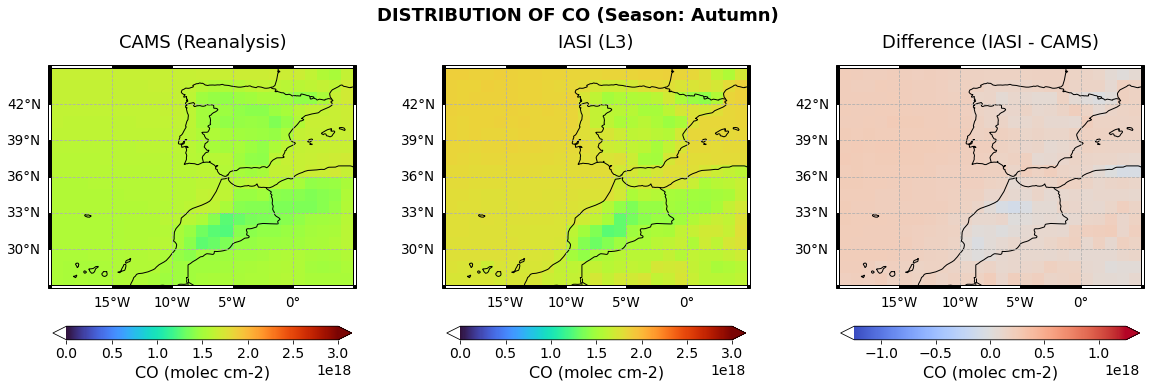

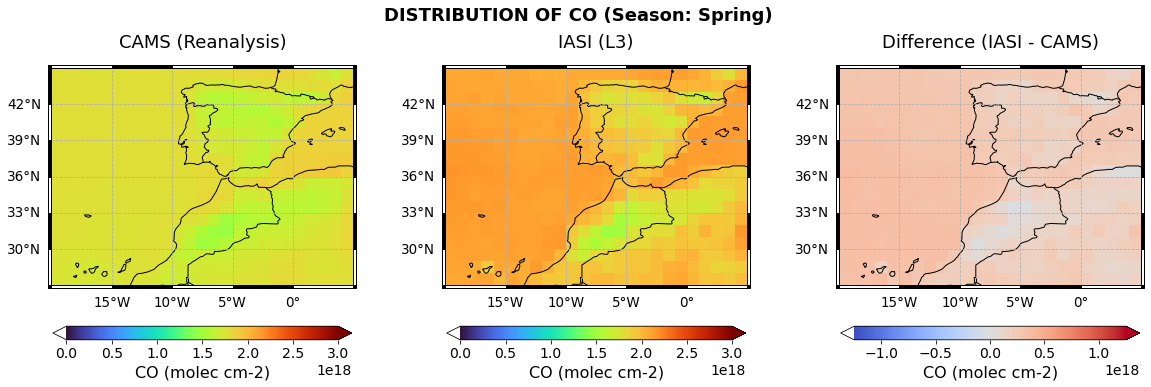

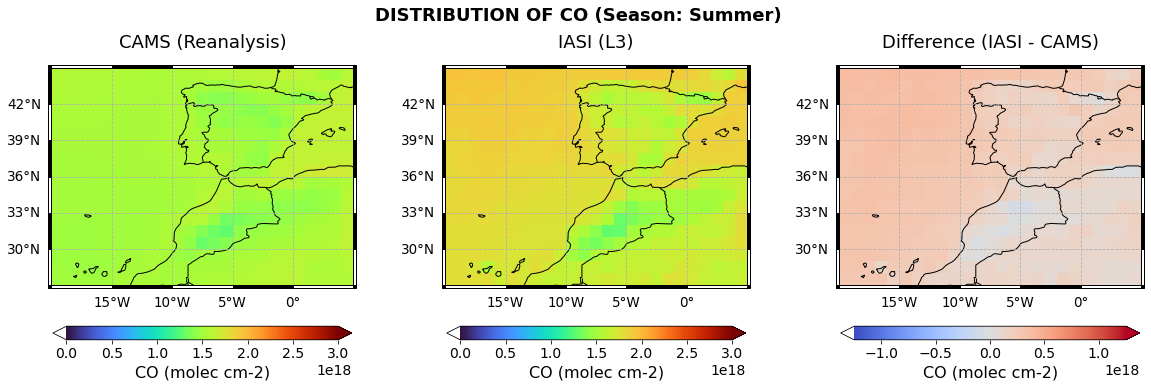

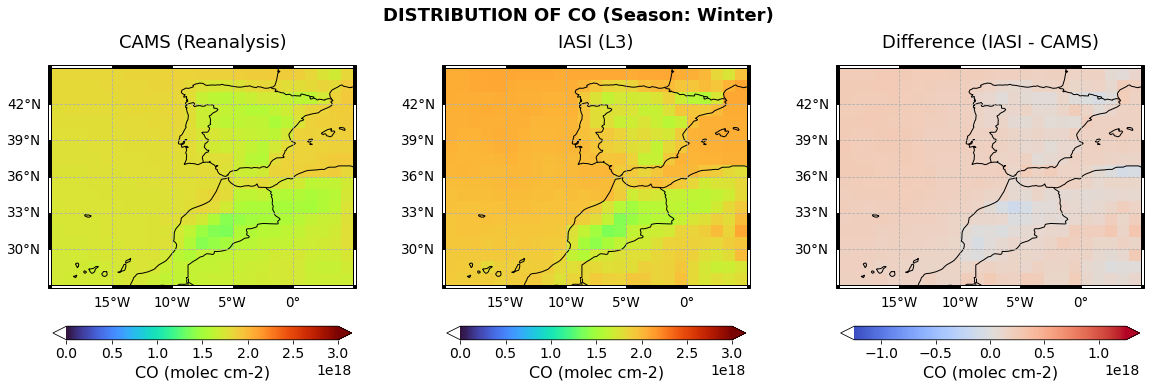

In [22]:
# Choose distribution (aggregated, individual, seasonal or animated)
distribution_type = 'seasonal'

# Choose range (original, equal or manual)
range_type = 'manual'
vmin_manual = 0
vmax_manual = 3*10**18

# Define projection and colors
projection = ccrs.PlateCarree()
color_scale = ['turbo', 'turbo', 'coolwarm']

# Get and decide the best width and height of the B/W frame lines
options_height_lon = get_frame_possible_lengths(lon_min, lon_max)
options_width_lat = get_frame_possible_lengths(lat_min, lat_max)
width_lon = 5
height_lat = 3

visualize_model_vs_sensor(model, sensor, component_nom, units, merge_df, plot_dates, plot_bbox, 20, 1.05, 
                          model_type, sensor_type, range_type, distribution_type, projection,
                          color_scale, width_lon, height_lat, vmin_manual, vmax_manual)

## 7. Retrieve nearest values to specific coordinates

model_column  \
region    lat_search lon_search latitude longitude time                       
Barcelona 41.37       2.17      41.5      2.5      2018-01-01  1.809138e+18   
                                                   2018-02-01  1.942834e+18   
                                                   2018-03-01  1.953445e+18   
                                                   2018-04-01  1.904153e+18   
                                                   2018-05-01  1.871416e+18   
...                                                                     ...   
Madrid    40.37      -3.68      40.5     -3.5      2020-08-01  1.366458e+18   
                                                   2020-09-01  1.529896e+18   
                                                   2020-10-01  1.565541e+18   
                                                   2020-11-01  1.512803e+18   
                                                   2020-12-01  1.565637e+18   

                                                               sensor_column  \
region    lat_search lon_search latitude longitude time                        
Barcelona 41.37       2.17      41.5      2.5      2018-01-01   1.874473e+18   
                                                   2018-02-01   2.100194e+18   
                                                   2018-03-01   2.111770e+18   
                                                   2018-04-01   2.094281e+18   
                                                   2018-05-01   2.060457e+18   
...                                                                      ...   
Madrid    40.37      -3.68      40.5     -3.5      2020-08-01   1.569241e+18   
                                                   2020-09-01   1.741703e+18   
                                                   2020-10-01   1.780040e+18   
                                                   2020-11-01   1.623932e+18   
                                                   2020-12-01   1.715416e+18   

                                                                 difference  \
region    lat_search lon_search latitude longitude time                       
Barcelona 41.37       2.17      41.5      2.5      2018-01-01  6.533500e+16   
                                                   2018-02-01  1.573605e+17   
                                                   2018-03-01  1.583254e+17   
                                                   2018-04-01  1.901285e+17   
                                                   2018-05-01  1.890405e+17   
...                                                                     ...   
Madrid    40.37      -3.68      40.5     -3.5      2020-08-01  2.027838e+17   
                                                   2020-09-01  2.118065e+17   
                                                   2020-10-01  2.144987e+17   
                                                   2020-11-01  1.111287e+17   
                                                   2020-12-01  1.497799e+17   

                                                               relative_difference  
region    lat_search lon_search latitude longitude time                             
Barcelona 41.37       2.17      41.5      2.5      2018-01-01            -0.034855  
                                                   2018-02-01            -0.074927  
                                                   2018-03-01            -0.074973  
                                                   2018-04-01            -0.090785  
                                                   2018-05-01            -0.091747  
...                                                                            ...  
Madrid    40.37      -3.68      40.5     -3.5      2020-08-01            -0.129224  
                                                   2020-09-01            -0.121609  
                                                   2020-10-01            -0.120502  
                               

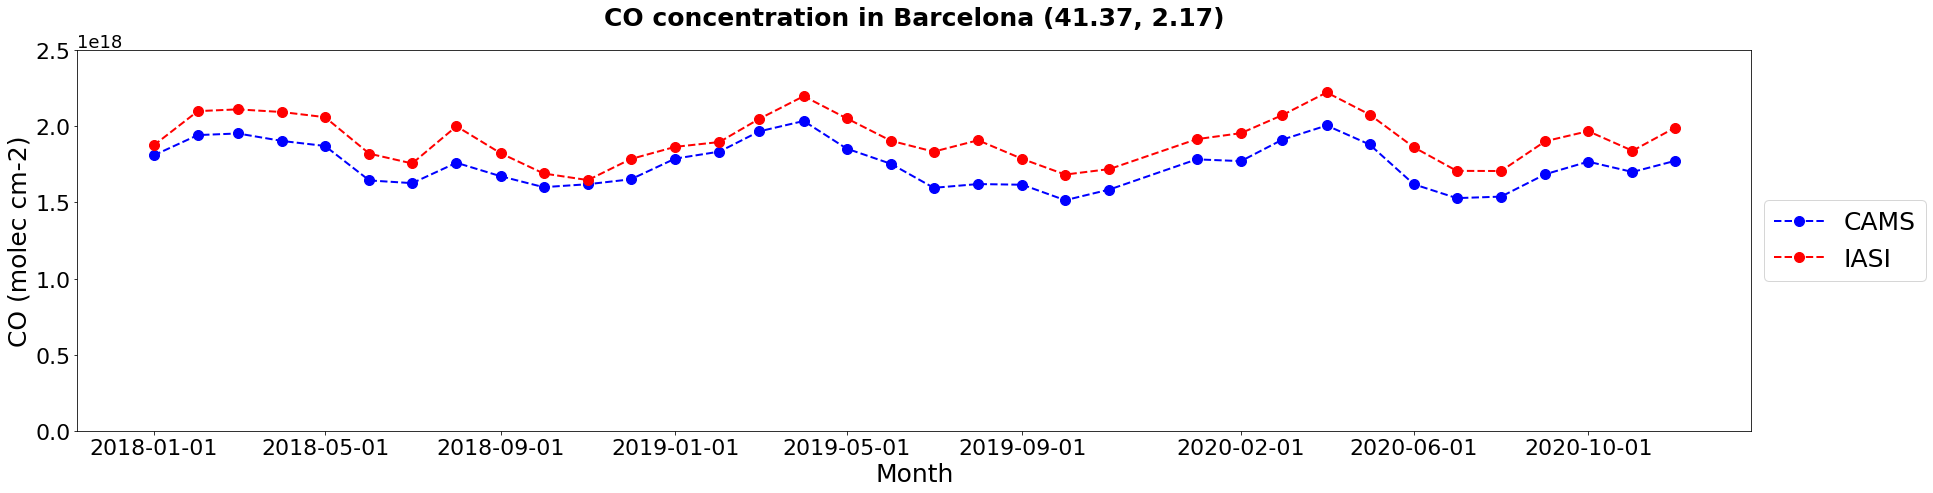

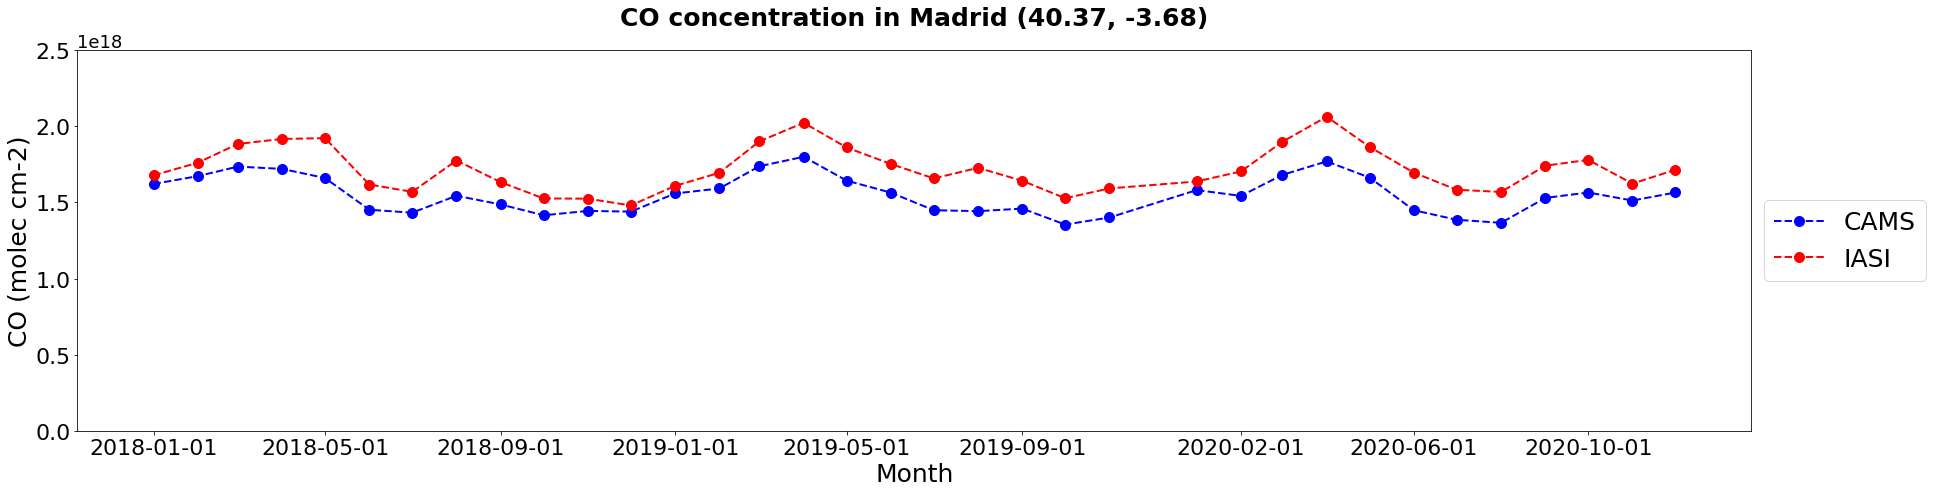

In [23]:
regions_names = ('Barcelona', 'Madrid')
coords_list = (41.37, 2.17,
               40.37, -3.68)
ymin = 0
ymax = 2.5*10**18
xticks = plot_dates[0::4]

timeseries_table = timeseries(merge_df.dropna(), component_nom, sensor, sensor_type, model, 
                              plot_dates, units, ymin, ymax, xticks, regions_names, coords_list)
timeseries_table

## 8. Monthly annual cycle

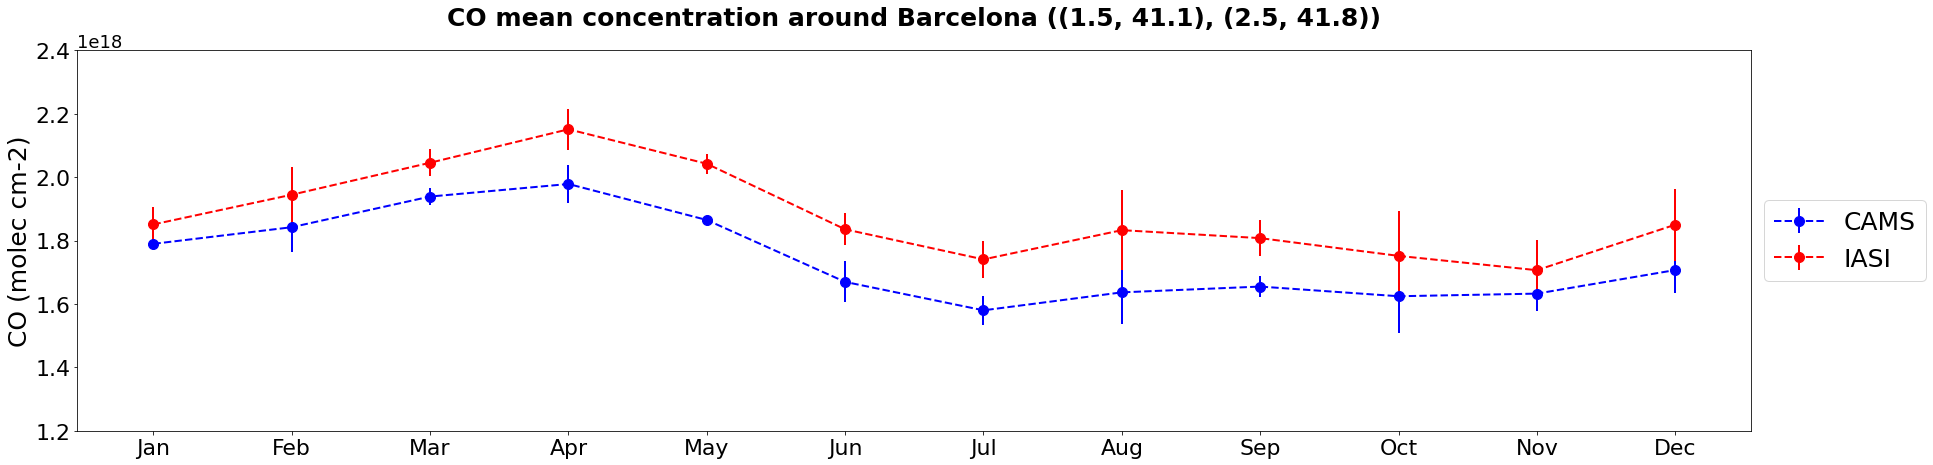

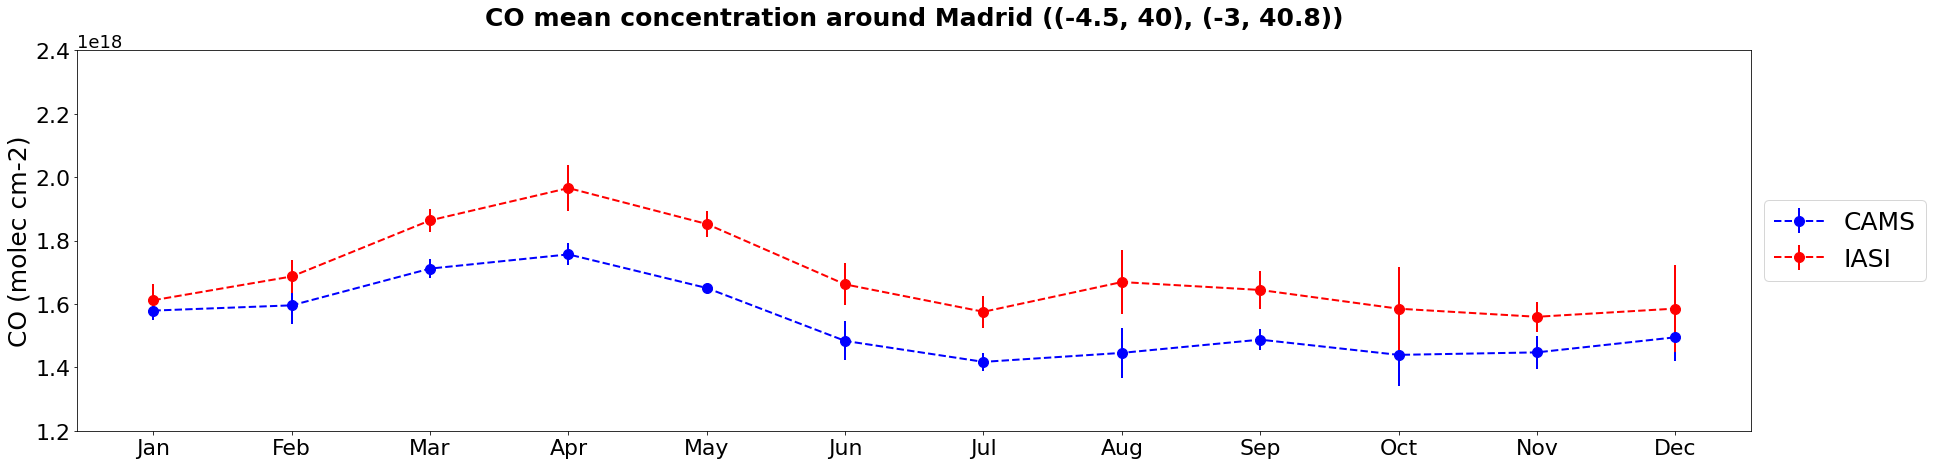

,location,month,model mean,model std,sensor mean,sensor std
0,Barcelona,1,1.789593e+18,1.213202e+16,1.850840e+18,5.416489e+16
1,Barcelona,2,1.842075e+18,7.729285e+16,1.944496e+18,8.893689e+16
2,Barcelona,3,1.938712e+18,2.595769e+16,2.045349e+18,4.228982e+16
3,Barcelona,4,1.978336e+18,6.144191e+16,2.150856e+18,6.540254e+16
4,Barcelona,5,1.864743e+18,1.366164e+16,2.042141e+18,3.078655e+16
5,Barcelona,6,1.669549e+18,6.447360e+16,1.835384e+18,5.064545e+16
6,Barcelona,7,1.579941e+18,4.586318e+16,1.740531e+18,5.872956e+16
7,Barcelona,8,1.636586e+18,9.910162e+16,1.832730e+18,1.266012e+17
8,Barcelona,9,1.654837e+18,3.411415e+16,1.807593e+18,5.655811e+16
9,Barcelona,10,1.624355e+18,1.162599e+17,1.751660e+18,1.423456e+17


In [24]:
regions_names = ('Barcelona', 'Madrid')
bbox_list = (41.1, 41.8, 1.5, 2.5,
             40, 40.8, -4.5, -3)
ymin = 1.2*10**18
ymax = 2.4*10**18

monthly_annual_cycle_table = monthly_annual_cycle(merge_df.dropna(), component_nom, sensor, model, units, 
                                                  ymin, ymax, regions_names, bbox_list)
monthly_annual_cycle_table

## 9. Trends

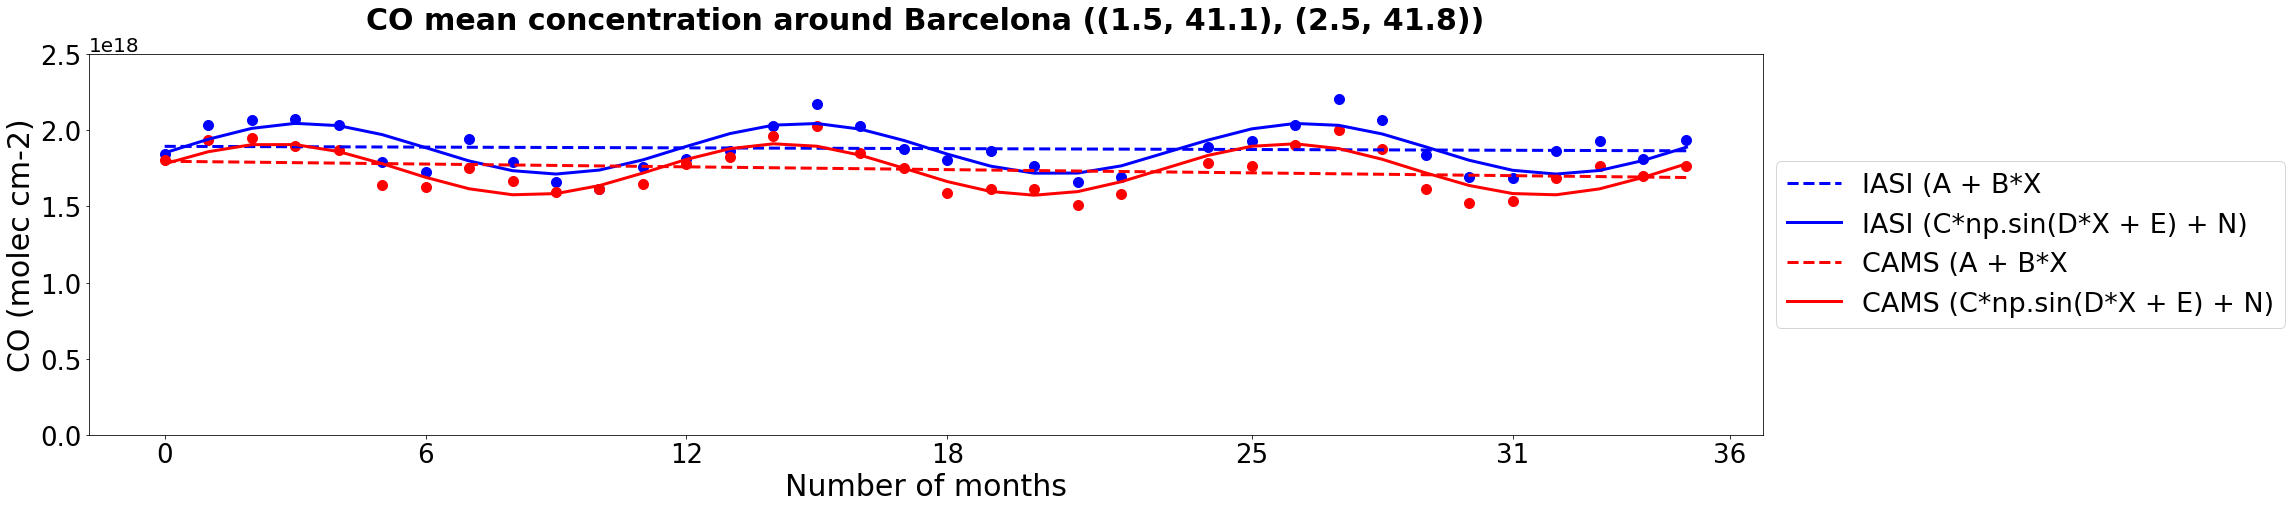

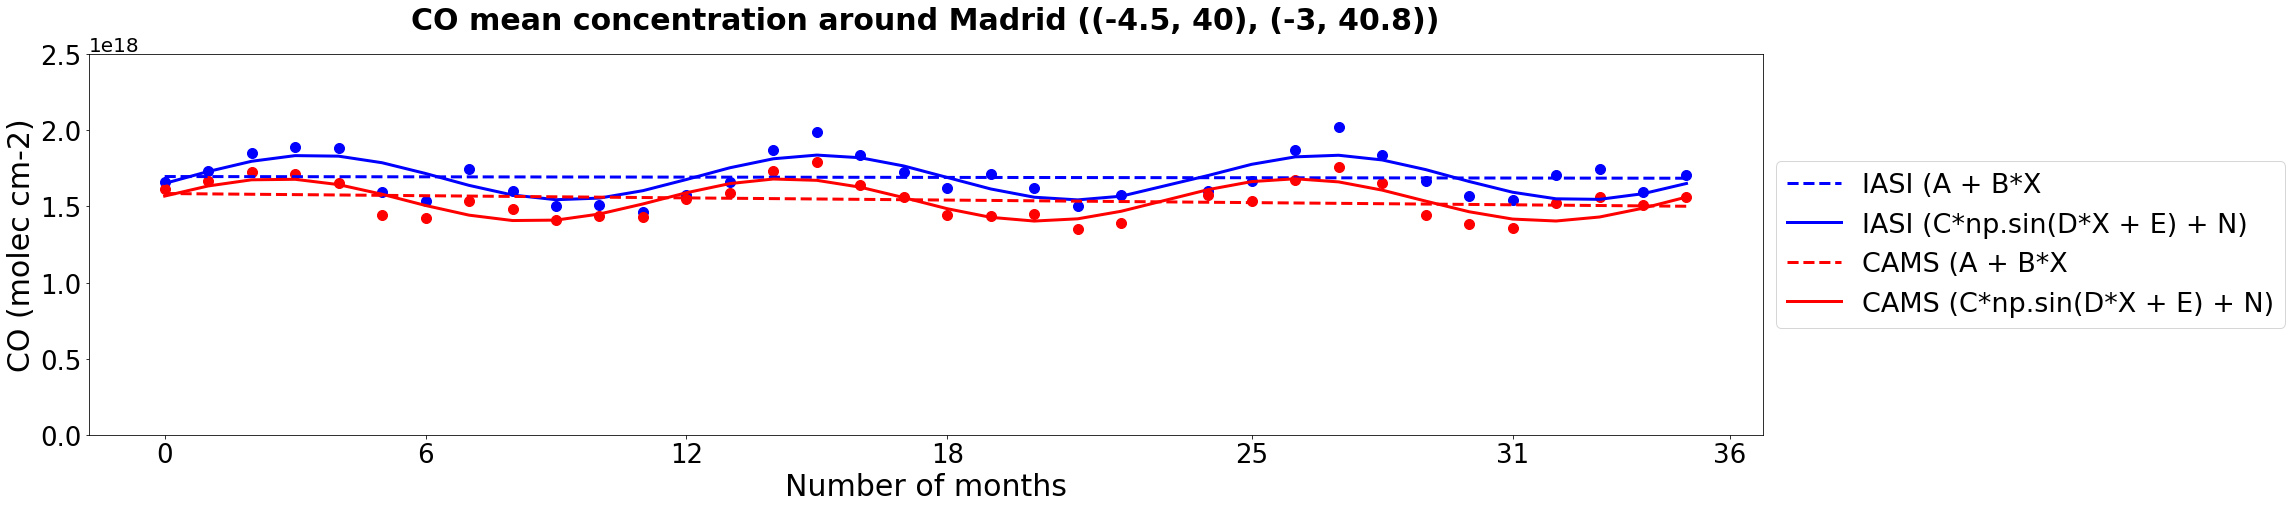

,Location,Source,Rate (molec cm-2 y-1),Rate (% y-1),A,B,C,D,E,N,Linear R2,Linear RMSE,Linear MSE,Sinusoidal R2,Sinusoidal RMSE,Sinusoidal MSE
0,Barcelona,Sensor,-9.997832e+15,-0.527552,1.895137e+18,-8.331527e+14,1.670282e+17,0.545027,-0.168952,1.880113e+18,0.003399,1.496980e+17,2.240950e+34,0.612981,9.328705e+16,8.702473e+33
1,Barcelona,Model,-3.661688e+16,-2.037505,1.797143e+18,-3.051407e+15,1.692058e+17,0.538654,0.219193,1.743360e+18,0.050248,1.392069e+17,1.937855e+34,0.703316,7.780417e+16,6.053489e+33
0,Madrid,Sensor,-3.804802e+15,-0.224237,1.696775e+18,-3.170668e+14,1.473249e+17,0.538525,-0.268876,1.690566e+18,0.000550,1.418020e+17,2.010781e+34,0.535784,9.664117e+16,9.339516e+33
1,Madrid,Model,-2.865270e+16,-1.807574,1.585147e+18,-2.387725e+15,1.390492e+17,0.537210,0.183384,1.543051e+18,0.042912,1.183275e+17,1.400140e+34,0.663162,7.019731e+16,4.927662e+33


In [25]:
regions_names = ('Barcelona', 'Madrid')
bbox_list = (41.1, 41.8, 1.5, 2.5,
             40, 40.8, -4.5, -3
            )
ymin = 0
ymax = 2.5*10**18
sensor_break_date = None # Date as a string or None
model_break_date = None # Date as a string or None

trends_table = trends(merge_df.dropna(), component_nom, sensor, model, units, ymin, ymax, 
                      plot_dates, regions_names, bbox_list, sensor_break_date, model_break_date)
trends_table

## 10. Scatter plots by bbox

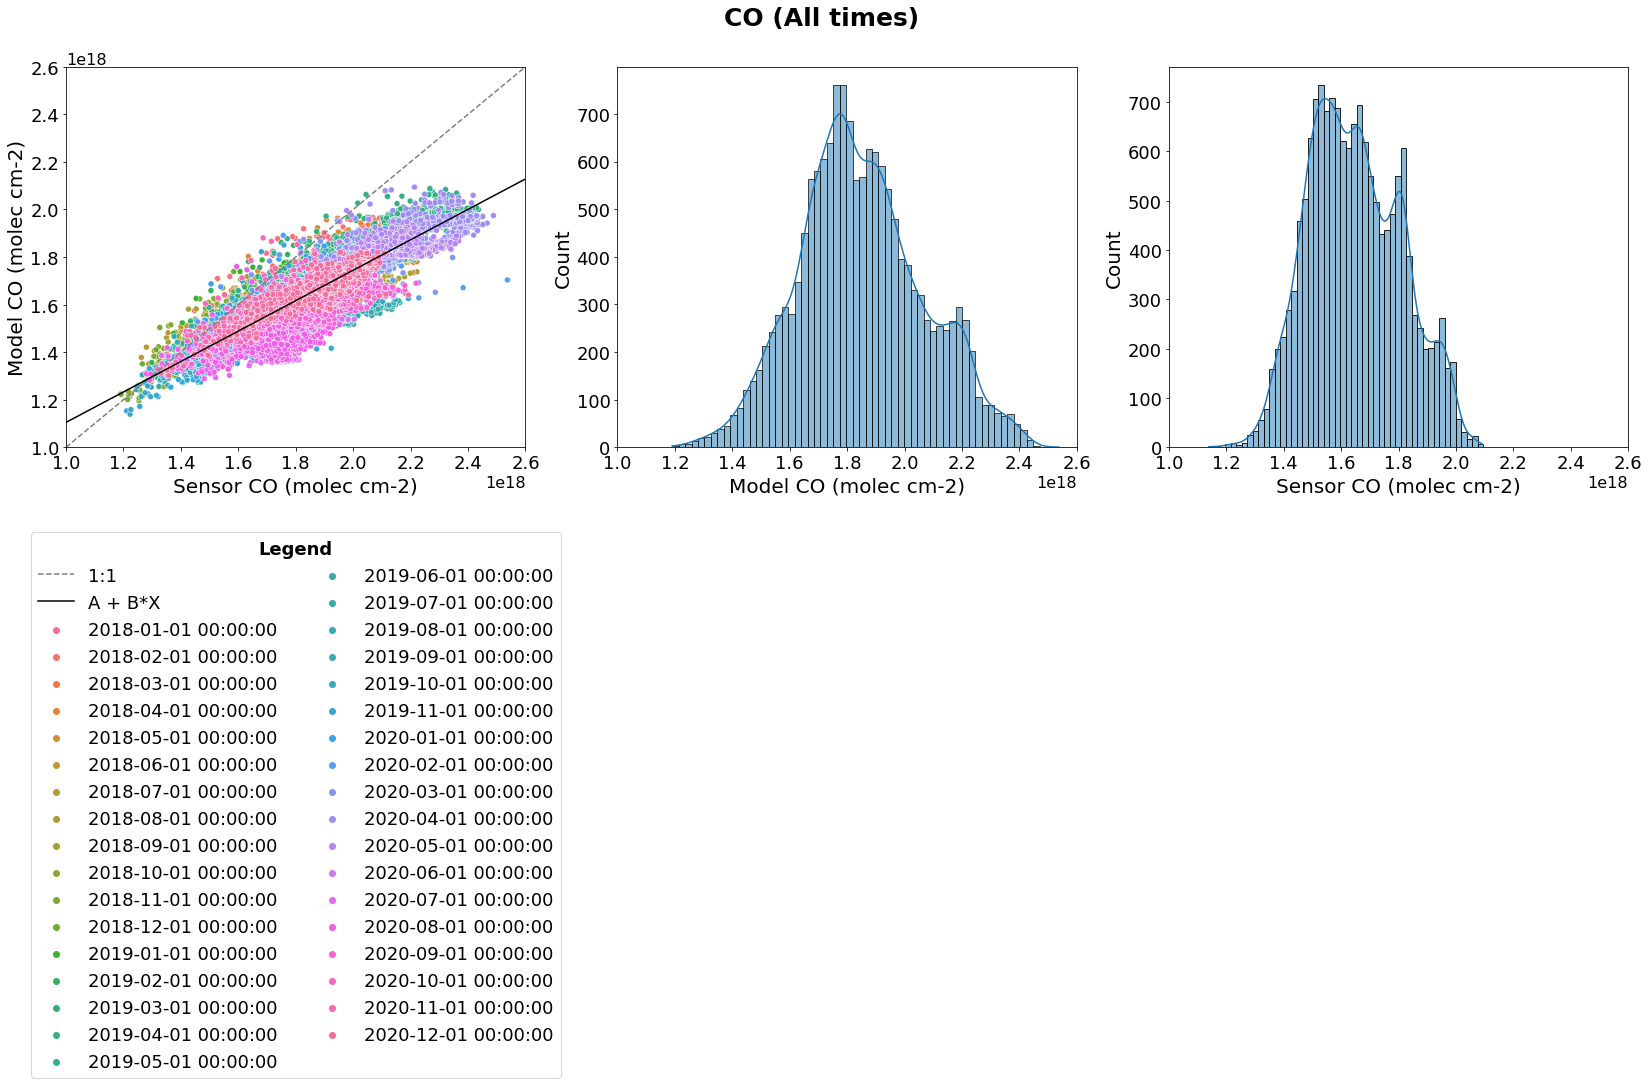

,Period,Location,A,B,R2,RMSE,MSE
0,"[2018-01-01T00:00:00.000000000, 2018-02-01T00:...","((-20, 27), (5, 45))",0.639876,4.647365e+17,0.74915,8.018356e+16,6.429403e+33


In [26]:
show_seasons = False
extent_definition = 'bbox' # bbox or country
scatter_plot_type = 'aggregated' # aggregated or individual

lim_min = 1*10**18
lim_max = 2.6*10**18

summary = scatter_plot(merge_df.dropna(), component_nom, units, sensor, plot_dates, 1, 
                       extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_bbox)
summary

## 11. Scatter plots by season

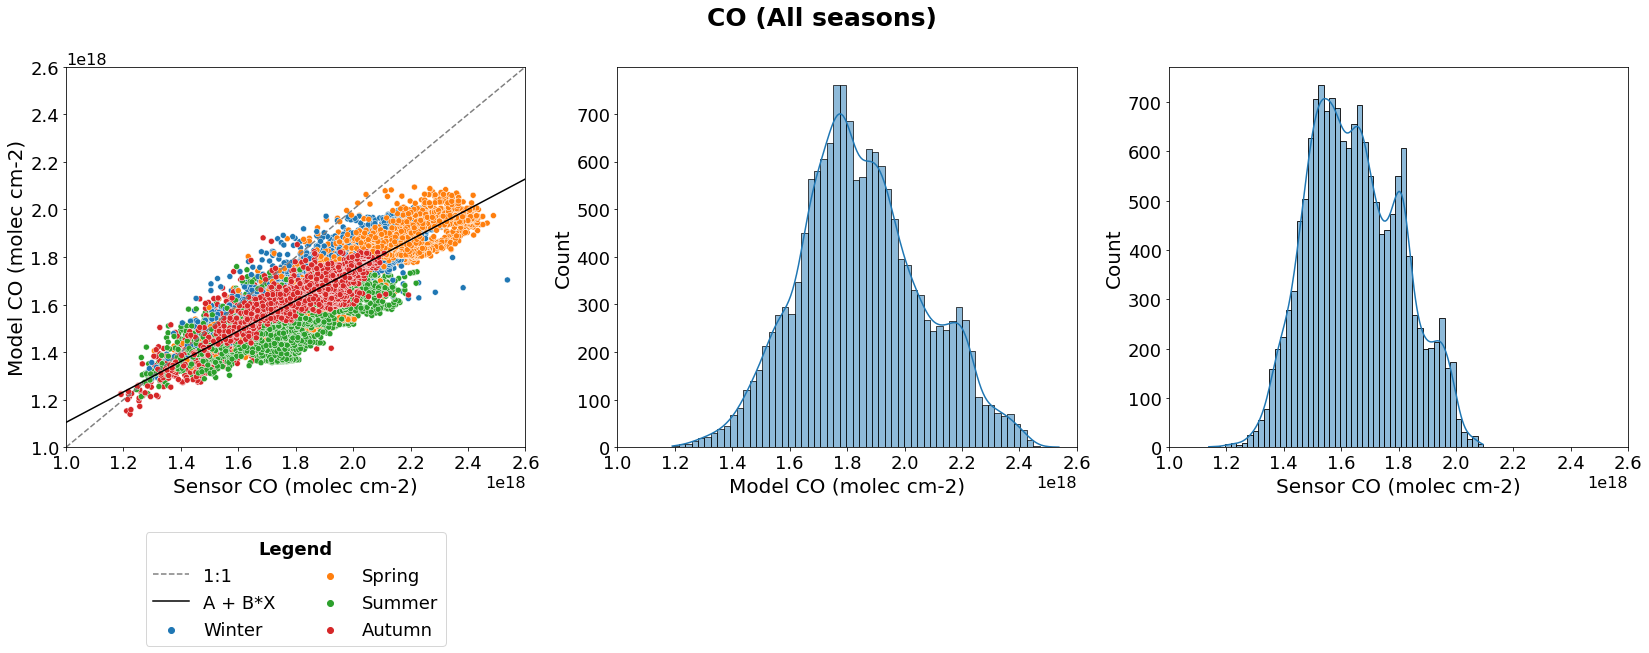

,Period,Location,A,B,R2,RMSE,MSE
0,"[Autumn, Spring, Summer, Winter]","((-20, 27), (5, 45))",0.639876,4.647365e+17,0.74915,8.018356e+16,6.429403e+33


In [27]:
show_seasons = True
extent_definition = 'bbox' # bbox or country
scatter_plot_type = 'aggregated' # aggregated or individual

lim_min = 1*10**18
lim_max = 2.6*10**18

summary = scatter_plot(merge_df.dropna(), component_nom, units, sensor, plot_dates, 1, 
                       extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_bbox)
summary

## 12. Scatter plots by country (Google API required!)

In [28]:
"""
show_seasons = False
extent_definition = 'country' # bbox or country
scatter_plot_type = 'individual' # aggregated or individual
plot_countries = ['France', 'Germany', 'Italy']

lim_min = 1*10**18
lim_max = 2.6*10**18

summary = scatter_plot(merge_df.dropna(), component_nom, units, sensor, plot_dates, 1, 
                       extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_countries)
summary
"""

"\nshow_seasons = False\nextent_definition = 'country' # bbox or country\nscatter_plot_type = 'individual' # aggregated or individual\nplot_countries = ['France', 'Germany', 'Italy']\n\nlim_min = 1*10**18\nlim_max = 2.6*10**18\n\nsummary = scatter_plot(merge_df.dropna(), component_nom, units, sensor, plot_dates, 1, \n                       extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_countries)\nsummary\n"